In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import copy

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta

,Unnamed: 0,Unnamed: 0.1,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,...,Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy,age_group,age_category
0,0,0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy,40-50,adult
1,1,1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy,70-80,senior
2,2,2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy,70-80,senior
3,3,3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy,40-50,adult
4,4,4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy,60-70,senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,4342,4342,SAMEA4431948,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431948,...,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,52212493.0,Unhealthy,10-20,child
4343,4343,4343,SAMEA4431949,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431949,...,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,50635879.0,Unhealthy,10-20,child
4344,4344,4344,SAMEA4431951,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431951,...,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,40712962.0,Unhealthy,10-20,child
4345,4345,4345,SAMEA4431964,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431964,...,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,38177360.0,Unhealthy,10-20,youth


In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'CRC', 'Crohns disease', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(3153, 903)

In [7]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Run PCA

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(MatrixData)

In [9]:
pca_model = PCA(n_components = 100)

In [10]:
X_PCA = pca_model.fit_transform(X_scaled)

<AxesSubplot:>

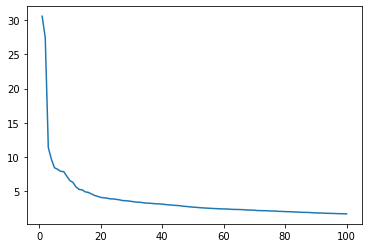

In [11]:
sns.lineplot(x = np.arange(1,101), y = pca_model.explained_variance_)

<AxesSubplot:>

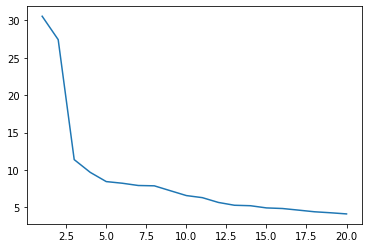

In [12]:
sns.lineplot(x = np.arange(1,21), y = pca_model.explained_variance_[0:20])

In [13]:
pca_model.components_.shape

(100, 903)

In [14]:
heatmap_df = FeatMeta
for i in range(21):
    PC_name = 'PC' + str(i)
    heatmap_df[PC_name] = pca_model.components_[i,:]

heatmap_df.index = heatmap_df['feature']
heatmap_df.pop('Unnamed: 0')
heatmap_df.pop('feature')
heatmap_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
feature,,,,,,,,,,,,,,,,,,,,,
s__Abiotrophia_defectiva,9.011337e-03,-6.002894e-04,1.291695e-01,-3.844550e-02,-1.918068e-02,-1.639060e-02,-3.089399e-03,-1.642546e-03,-1.169375e-02,-2.896879e-04,...,1.221285e-01,4.402046e-02,2.074395e-02,-6.616804e-03,-3.096744e-02,-1.867532e-02,-1.377967e-02,1.754702e-02,1.038278e-02,-2.667635e-02
s__Acetobacter_unclassified,-1.167476e-04,-1.124826e-04,-1.664706e-03,5.295895e-04,-6.908176e-04,-7.619430e-04,1.446255e-03,-1.503460e-03,-5.725011e-04,2.708843e-03,...,-1.346904e-03,7.505810e-04,-5.497279e-04,4.759443e-03,1.668781e-04,-6.095380e-03,2.535064e-03,-1.204595e-03,3.385729e-03,-1.358142e-04
s__Achromobacter_piechaudii,-2.201070e-19,5.702307e-19,1.341186e-17,5.661166e-17,9.722793e-17,-1.406117e-16,1.195448e-16,1.383849e-17,2.438769e-16,-5.840172e-17,...,-1.324114e-16,1.019070e-16,4.042916e-17,-1.129784e-16,-4.772450e-18,3.559985e-17,-5.596490e-17,3.001506e-18,1.072852e-16,-5.123332e-17
s__Achromobacter_unclassified,8.919876e-05,5.930127e-03,-2.304934e-04,5.567014e-04,-2.205135e-02,-6.922240e-03,2.367199e-01,2.603162e-01,3.137097e-03,2.825782e-03,...,4.095762e-03,1.150936e-03,9.931593e-04,-8.093166e-03,-8.414855e-03,5.380515e-03,-4.214419e-03,-4.188705e-03,-7.049004e-03,-2.205919e-03
s__Achromobacter_xylosoxidans,4.650615e-20,3.159608e-19,-1.462045e-17,-3.823805e-18,1.285461e-16,6.859763e-17,-1.452626e-16,4.634411e-17,-8.949348e-17,-4.867707e-17,...,-1.221123e-17,1.826799e-17,6.593826e-17,9.960918e-18,5.321262e-17,7.820141e-19,-6.985089e-17,-3.521052e-18,6.252027e-18,3.052560e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s__Weissella_koreensis,4.860926e-05,-1.388136e-04,3.088323e-03,1.813779e-03,-1.902882e-03,1.673850e-04,3.003109e-03,-2.472249e-03,-8.812565e-04,1.391197e-03,...,-1.190426e-02,4.992547e-03,-2.991238e-03,1.608147e-02,-1.971734e-03,-1.522723e-02,-3.101749e-04,-6.870883e-04,-9.094993e-03,3.993486e-04
s__Weissella_paramesenteroides,1.285361e-03,-2.002738e-04,4.499591e-02,-1.494764e-02,-6.153432e-03,-1.543983e-02,-7.066548e-03,5.647537e-03,-1.028075e-02,8.002253e-03,...,-7.464966e-03,-5.215750e-03,-3.587122e-02,2.011548e-02,8.695559e-02,1.216199e-02,-1.330710e-01,-7.371420e-02,1.066207e-01,8.668939e-02
s__Weissella_unclassified,3.532209e-04,-5.339929e-04,1.984559e-02,-3.203159e-03,-1.277106e-02,3.736186e-04,7.653311e-03,-8.140091e-03,-1.834295e-03,9.383361e-03,...,-1.673126e-02,8.194161e-03,-7.094393e-03,5.508387e-03,-4.245434e-03,-6.954994e-03,-1.462390e-02,-5.349451e-04,-1.189836e-02,-5.164935e-03


/root/anaconda/envs/microbiome/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


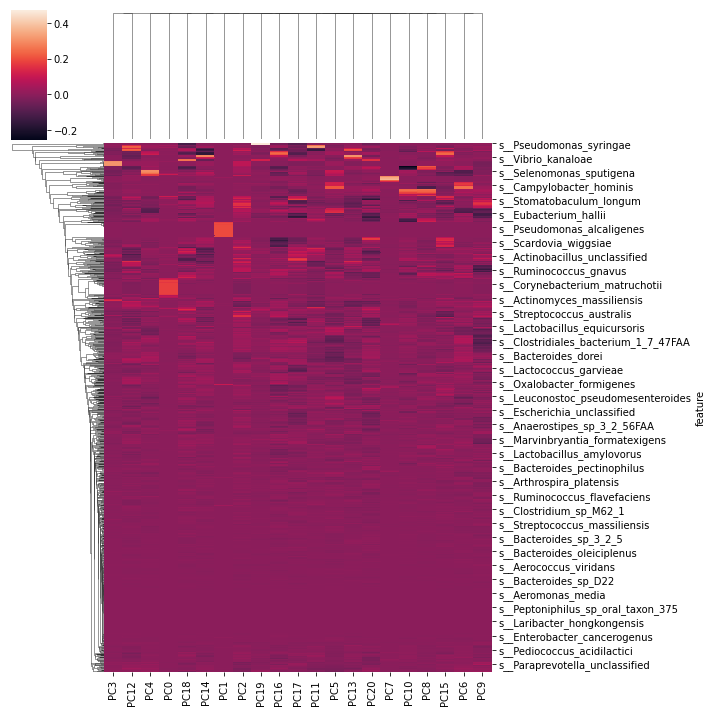

In [14]:
sns.clustermap(heatmap_df)

Overall, we don't see super blocky strucutre

In [15]:
# get maximum PC loading
max_loading = np.array([np.max(pca_model.components_[:, i]) for i in range(pca_model.components_.shape[1])])

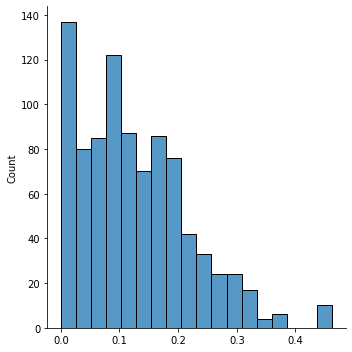

In [16]:
# distribution of maximum PC loadings across ~900 features
sns.displot(max_loading)

It seems like most features are at least somewhat important, while there are a handful that are really important to variation

In [17]:
heatmap_df['PC1'].sort_values(ascending = False)[0:40]

feature
s__Riemerella_unclassified           0.190755
s__Pseudoxanthomonas_unclassified    0.190720
s__Chryseobacterium_unclassified     0.190720
s__Leucobacter_unclassified          0.190720
s__Myroides_unclassified             0.190720
s__Pseudomonas_mendocina             0.190720
s__Methyloversatilis_unclassified    0.190720
s__Pseudomonas_stutzeri              0.190720
s__Pseudomonas_alcaligenes           0.190720
s__Limnohabitans_unclassified        0.190720
s__Enhydrobacter_aerosaccus          0.190720
s__Verminephrobacter_unclassified    0.190720
s__Thauera_phenylacetica             0.190720
s__Sphingobacterium_unclassified     0.190720
s__Brevundimonas_diminuta            0.190720
s__Delftia_acidovorans               0.190720
s__Pseudomonas_denitrificans         0.190720
s__Pseudomonas_nitroreducens         0.190720
s__Arcobacter_unclassified           0.190705
s__Pseudomonas_unclassified          0.190352
s__Acinetobacter_ursingii            0.190045
s__Brevundimonas_unclassif

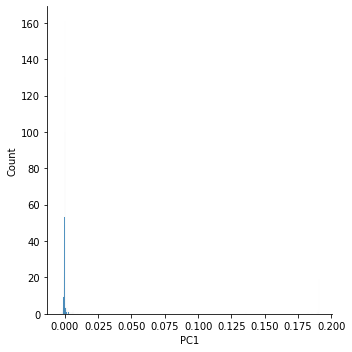

In [18]:
sns.displot(heatmap_df['PC1'])

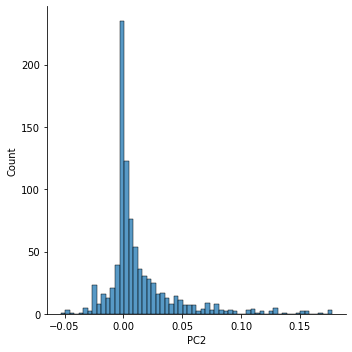

In [19]:
sns.displot(heatmap_df['PC2'])

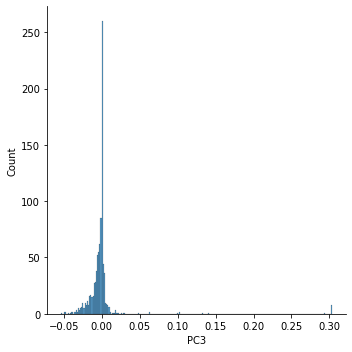

In [20]:
sns.displot(heatmap_df['PC3'])

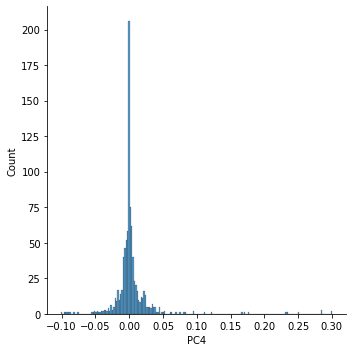

In [21]:
sns.displot(heatmap_df['PC4'])

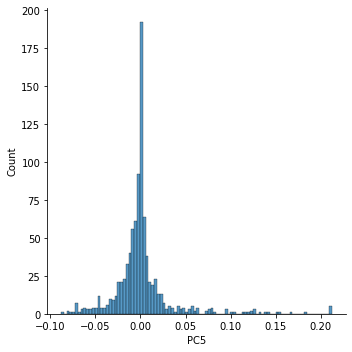

In [22]:
sns.displot(heatmap_df['PC5'])

Individual PCs tend to be dominated by a small minority of features

In [21]:
for i in range(0, 100):
    PC_name = 'PC' + str(i + 1)
    SampleMeta[PC_name] = X_PCA[:, i]

/root/anaconda/envs/microbiome/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

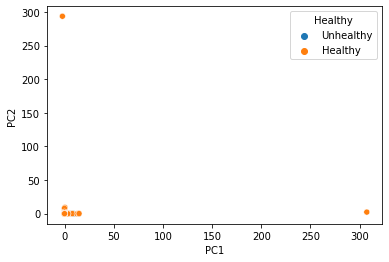

In [23]:
sns.scatterplot(data = SampleMeta, x = 'PC1', y = 'PC2', hue = 'Healthy')

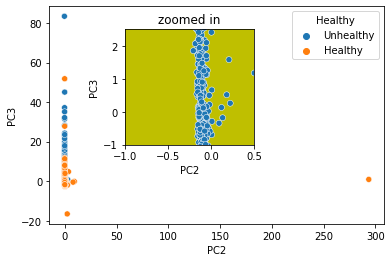

In [62]:
import matplotlib.pyplot as plt
sns.scatterplot(data = SampleMeta, x = 'PC2', y = 'PC3', hue = 'Healthy')
ax2 = plt.axes([0.3, 0.4, .3, .4], facecolor='y')
sns.scatterplot(data = SampleMeta[SampleMeta["Healthy"]=="Unhealthy"], x = 'PC2', y = 'PC3', hue = 'Healthy', ax=ax2)
ax2.set_title('zoomed in')
ax2.set_xlim([-1, 0.5])
ax2.set_ylim([-1, 2.5])
plt.legend([],[], frameon=False)

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

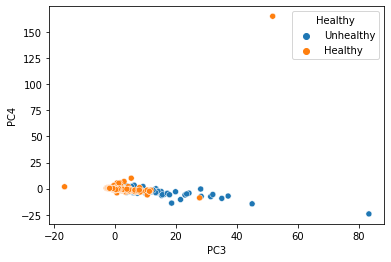

In [45]:
sns.scatterplot(data = SampleMeta, x = 'PC3', y = 'PC4', hue = 'Healthy')

<AxesSubplot:xlabel='PC4', ylabel='PC5'>

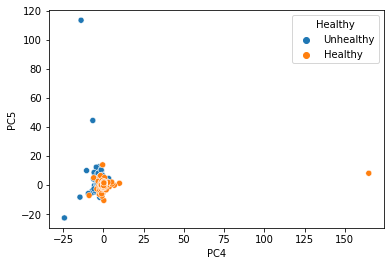

In [46]:
sns.scatterplot(data = SampleMeta, x = 'PC4', y = 'PC5', hue = 'Healthy')

<AxesSubplot:xlabel='PC15', ylabel='PC16'>

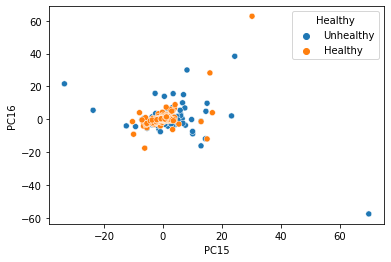

In [47]:
sns.scatterplot(data = SampleMeta, x = 'PC15', y = 'PC16', hue = 'Healthy')

<AxesSubplot:xlabel='PC17', ylabel='PC18'>

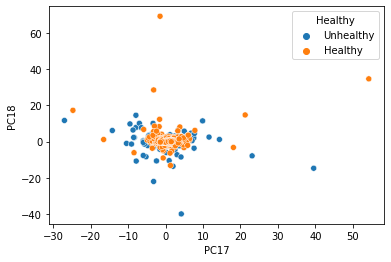

In [48]:
sns.scatterplot(data = SampleMeta, x = 'PC17', y = 'PC18', hue = 'Healthy')

<AxesSubplot:xlabel='PC19', ylabel='PC20'>

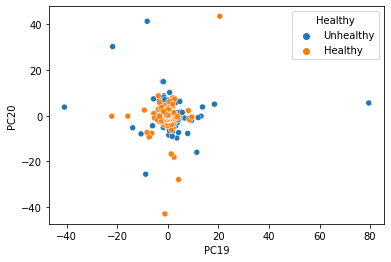

In [49]:
sns.scatterplot(data = SampleMeta, x = 'PC19', y = 'PC20', hue = 'Healthy')

Overall, it doesn't appear that health status really as too much to do with the first few PCs, although picture becomes more interesting at higher PCs. First few PCs look to be outlier effects TODO: Train LR model that just uses PCA results, or try KNN

In [31]:
heatmap_df_samples = SampleMeta[['Healthy', 'Phenotype']]
pc_cols = np.array(['PC' + str(i + 1) for i in range(0,20)])
for pc in pc_cols:
    heatmap_df_samples[pc] = SampleMeta[pc]
    
heatmap_df_samples

/root/anaconda/envs/microbiome/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Healthy,Phenotype,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,Unhealthy,ACVD,1.784576,-0.232666,29.790850,-6.572769,-2.653574,-5.801088,1.153820,-0.670039,...,-1.916240,-6.648084,0.696971,-7.478313,6.372286,-8.147826,9.428580,-6.547975,7.866899,1.057340
1,Unhealthy,ACVD,0.243618,-0.132562,2.954659,-0.053701,1.470880,-3.532588,1.877072,0.069204,...,0.692400,4.927800,-2.235110,1.215884,-3.264441,1.866417,-1.006320,2.903712,3.438822,0.621139
2,Unhealthy,ACVD,-0.180335,-0.113250,0.738989,-0.139017,0.600442,-2.056210,1.320835,-0.098215,...,0.739522,-0.186255,-0.663563,1.023332,-0.144822,-0.536329,0.420144,1.507209,-0.772994,-0.004675
3,Unhealthy,ACVD,0.058698,-0.110921,5.267182,-1.047231,-0.941230,-1.141590,-0.165357,-0.006397,...,0.590453,-1.733510,2.611424,4.845247,-2.224233,1.003971,-3.998754,-1.921070,-0.355469,-0.646607
4,Unhealthy,ACVD,0.599145,-0.180566,6.088577,-2.025676,-1.100533,0.304291,-0.154168,-0.440644,...,-0.224447,0.000973,0.625136,-1.012649,0.263119,-0.689325,4.738592,2.309896,0.271403,1.047130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,Unhealthy,Underweight,-0.057634,-0.146836,4.010571,-1.363476,-0.514209,-2.105568,0.971657,-0.207070,...,1.200581,-0.375933,-0.293942,0.366575,0.918775,-2.167964,1.954555,0.360690,-1.168509,0.225717
4343,Unhealthy,Underweight,-0.200779,-0.061295,-1.185960,0.241116,1.171299,-2.116357,1.439750,-0.061254,...,0.066333,-0.653314,0.439817,-0.254482,0.180804,0.148140,0.066037,0.287053,-0.434453,0.302202
4344,Unhealthy,Underweight,-0.189474,-0.025933,0.127366,-0.144253,-1.074582,1.462347,-0.921931,-0.043197,...,0.161843,0.476624,-0.407984,0.710101,-0.138992,0.090159,-0.440900,0.405734,0.368297,0.247905
4345,Unhealthy,Underweight,-0.246452,-0.105735,-0.645939,0.129714,0.972356,-2.194304,1.373658,-0.136886,...,0.463331,-0.503853,-0.300473,0.522431,0.103595,-0.649960,0.257175,0.863250,-0.871652,0.200033


In [32]:
healthy = heatmap_df_samples.pop('Healthy')
pheno = heatmap_df_samples.pop('Phenotype')

/root/anaconda/envs/microbiome/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


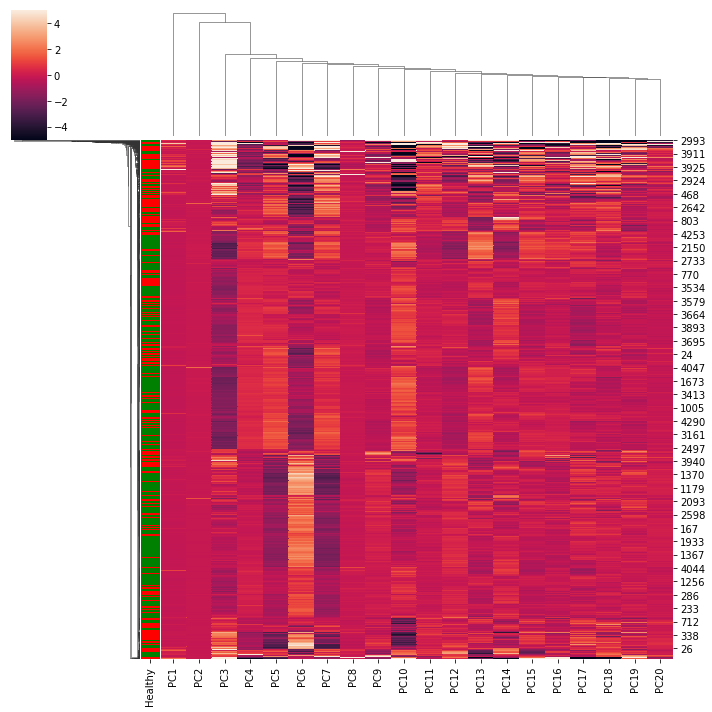

In [33]:
lut_healthy = dict(zip(healthy.unique(), 'rg'))
row_colors_health = healthy.map(lut_healthy)
sns.clustermap(heatmap_df_samples, row_colors=row_colors_health, vmin = -5, vmax = 5)

In [34]:
lut_healthy

{'Unhealthy': 'r', 'Healthy': 'g'}

In [35]:
np.mean(heatmap_df_samples.iloc[0:1000, :].to_numpy())

0.047326137094688366

In [36]:
np.std(heatmap_df_samples.iloc[0:1000, :].to_numpy())

3.343913285826335

It doesn't look like healthy samples cleanly cluster on their own in PCA space. This may be part of the reason why getting above 70% balanced accuracy is difficult

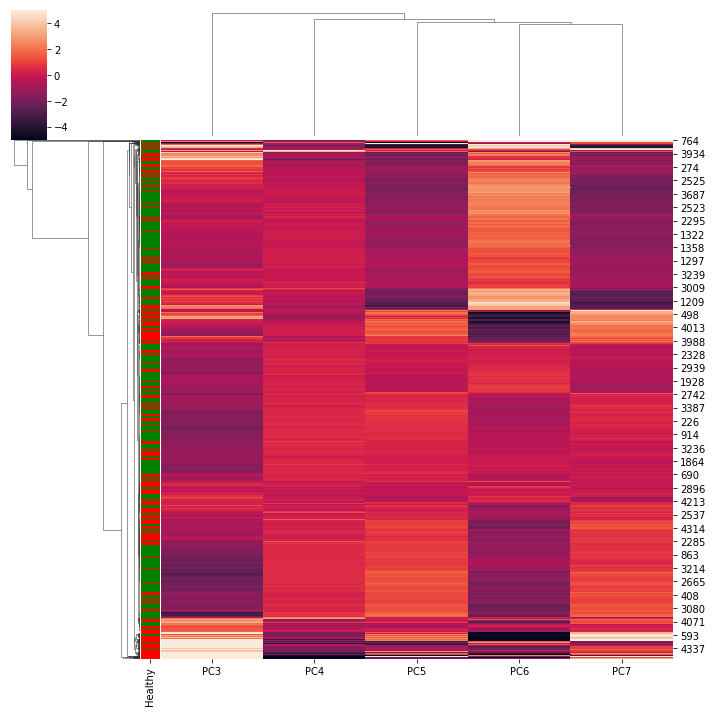

In [37]:
sns.clustermap(heatmap_df_samples[['PC3', 'PC4', 'PC5', 'PC6', 'PC7']], row_colors=row_colors_health, vmin = -5, vmax = 5)